# Pendulum- 1: Forward Problem
- PDE Solution Without Training Data
- Theoritical description of motion of simple pendulum ([aritcle](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html)).

## Description

**Governing Equation:**
- $ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin(\theta) = 0 } $

**Initial Conditions:**
- $ \displaystyle{ \theta(t=0) = 45\degree } $

- $ \displaystyle{ \frac{d\theta}{dt}(t=0) = 0 } $

**Methodology:**
- The above 3 equations will be the `loss function` of the neural network.
- The governing PDE "infroms" the neural network regrading the "physics".
- The initial conditions provide the contraints and prevent the neural network from converging to a trivial solution, i.e., weights and biases equal to 0 value (so as to minimize the loss).

**Inputs to NN:**
- We wish to have a neural network that can predict the motion of a pendulum for predifined value of $g = 9.8 m/s^2$ and $L = 0.5 m$ at any time `t`, for the aforementioned initial contidions.
- Thus, we will have only one input features: 
    - `t` : time

**Output of NN:**
- The NN will have a single output:
    - $\theta(t)$ : angular displacement of the pendulum at time `t`.
- The output along with its derivatives ($d\theta/dt$ and $d^2\theta/dt^2$) will be used to compute the losses.


## Using `scipy` library

### Function definition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE system for the pendulum
def pendulum_ode(t, y, g, L):
    """
    Defines the system of ODEs for the pendulum.
    
    Parameters:
    - t: Time variable (not used explicitly as the system is autonomous).
    - y: Array where y[0] is theta (angle) and y[1] is omega (angular velocity).
    - g: Acceleration due to gravity.
    - L: Length of the pendulum.
    
    Returns:
    - dydt: Array containing derivatives [dtheta/dt, domega/dt].
    """
    theta, omega = y  # Unpack theta and omega from the state array
    dtheta_dt = omega  # Angular velocity
    domega_dt = -(g / L) * np.sin(theta)  # Angular acceleration
    return [dtheta_dt, domega_dt]


### Solution

In [2]:
# Parameters
g = 9.8  # Acceleration due to gravity (m/s^2)
L = 0.5  # Length of the pendulum (meters)
theta0 = np.radians(45)  # Initial angle (converted to radians)
omega0 = 0  # Initial angular velocity (rad/s)

# Time parameters
t0 = 0  # Initial time (seconds)
t_end = 5  # End time (seconds)

# Initial state
y0 = [theta0, omega0]  # Initial conditions: [theta, omega]

# Solve the ODE using solve_ivp (Runge-Kutta method is default)
solution = solve_ivp(
    pendulum_ode,  # Function defining the ODE system
    [t0, t_end],   # Time span for the solution
    y0,            # Initial conditions
    t_eval=np.linspace(t0, t_end, 501),  # Time points where the solution is evaluated
    args=(g, L)    # Additional arguments passed to the ODE function
)

# Extract results
t_values = solution.t  # Time points
theta_values = solution.y[0]  # Theta values (angular displacement)


### Plot

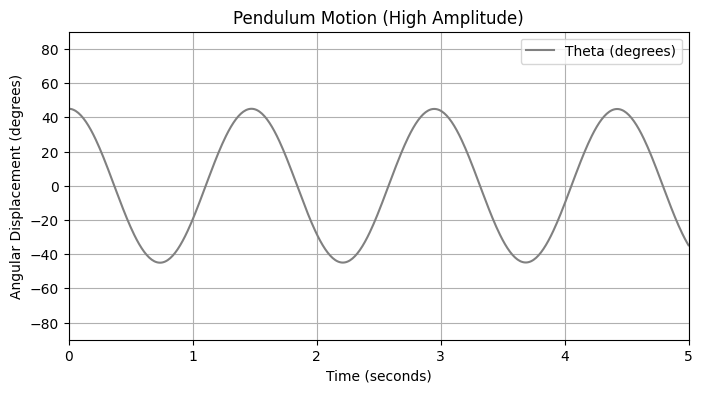

In [3]:
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t_values, np.degrees(theta_values), color="gray", label="Theta (degrees)")
plt.title("Pendulum Motion (High Amplitude)")
plt.xlabel("Time (seconds)")
plt.ylabel("Angular Displacement (degrees)")
plt.axis([0, t_end, -90, 90])
plt.grid()
plt.legend()
plt.show()


### Small angle approximation VS. Large angle numeric solution

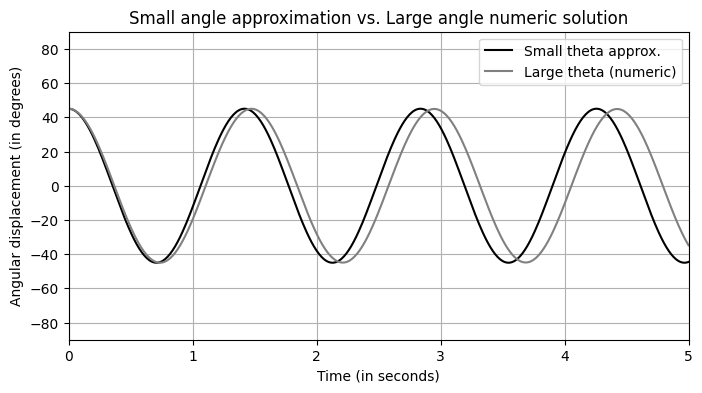

In [4]:
omega0 = np.sqrt(g/L)
theta_approx = theta0 * np.cos( omega0 * t_values )

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t_values, np.degrees(theta_approx), color="black", label="Small theta approx.")
plt.plot(t_values, np.degrees(theta_values), color="gray", label="Large theta (numeric)")
plt.axis([0, t_end, -90, 90])
plt.ylabel("Angular displacement (in degrees)")
plt.xlabel("Time (in seconds)")
plt.title("Small angle approximation vs. Large angle numeric solution")
plt.grid("on")
plt.legend(loc="upper right")
plt.show()


## Import Libraries

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## PINN Model

In [6]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


## Data for Validation

**Uniform Sampling**

In [7]:
# conert numpy to torch
t_values = torch.from_numpy(t_values)
theta_values = torch.from_numpy(theta_values)


C:\Users\E40065690\AppData\Local\Temp\ipykernel_26164\938222926.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(t_obs, np.degrees(theta_obs), label="observational")
C:\Users\E40065690\AppData\Local\Temp\ipykernel_26164\938222926.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(t_values, np.degrees(theta_values), label="Numeric solution", color="tab:grey", alpha=0.6)


<Figure size 400x200 with 0 Axes>

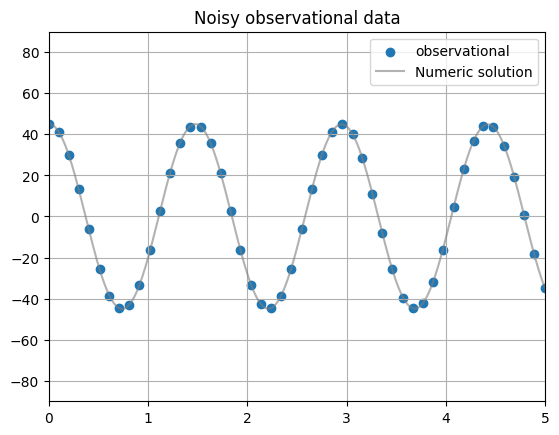

In [8]:
# Set random seed
torch.manual_seed(42)

# Ensure both arrays have the same length
assert len(t_values) == len(theta_values), "Arrays must have the same length."

# Total number of elements to extract
num_samples = 50

# Compute evenly spaced indices
indices = torch.linspace(0, len(t_values) - 1, num_samples, dtype=int).view(-1, 1)

# observational data
t_obs = t_values[indices].view(-1, 1)
theta_obs = theta_values[indices] #+ 0.05*torch.randn_like(t_obs) # 0.05*np.random.randn(len(t_obs))

# Plot the results
plt.figure(figsize=(4, 2))
plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs, np.degrees(theta_obs), label="observational")

# Numeric solution
plt.plot(t_values, np.degrees(theta_values), label="Numeric solution", color="tab:grey", alpha=0.6)
plt.legend(loc="upper right")
plt.axis([0, t_end, -90, 90])
plt.grid("on")
plt.show()


## Training: Self-supervised (without training data)

**Governing Equation:**
- $ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin(\theta) = 0 } $

**Initial Conditions:**
- $ \displaystyle{ \theta(t=0) = 45\degree } $

- $ \displaystyle{ \frac{d\theta}{dt}(t=0) = 0 } $


Loss Total     = tensor(77.3554, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(4.3281, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(62.9393, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(10.0880, grad_fn=<MulBackward0>)


C:\Users\E40065690\AppData\Local\Temp\ipykernel_26164\600841035.py:65: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(t_obs[:,0], np.degrees(theta_obs[:,0]), label="Validation Data", alpha=0.6)
C:\Users\E40065690\AppData\Local\Temp\ipykernel_26164\600841035.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(t_obs[:,0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="tab:green")


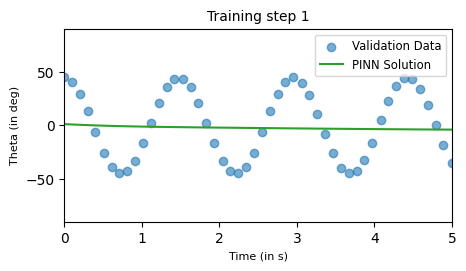

Loss Total     = tensor(1.5488, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(1.5122, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(0.0366, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(8.6958e-06, grad_fn=<MulBackward0>)


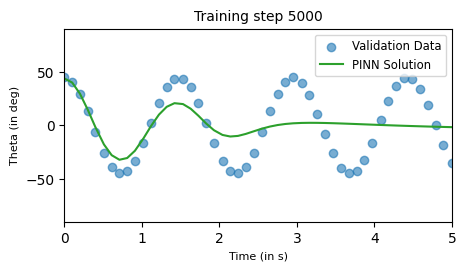

Loss Total     = tensor(1.3671, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(1.3382, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(0.0288, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(4.6872e-06, grad_fn=<MulBackward0>)


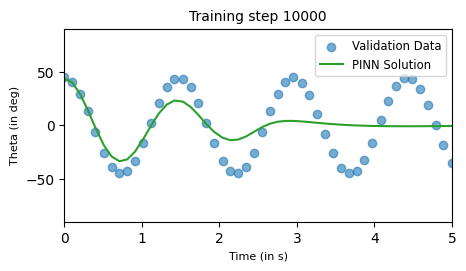

Loss Total     = tensor(1.1464, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(1.1270, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(0.0193, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(6.3111e-05, grad_fn=<MulBackward0>)


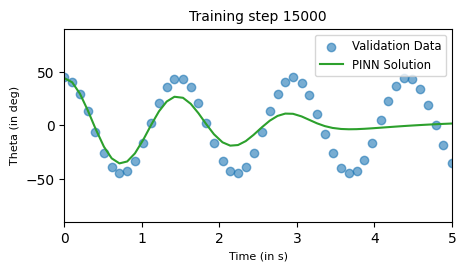

Loss Total     = tensor(0.6335, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(0.6282, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(0.0053, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(1.0013e-06, grad_fn=<MulBackward0>)


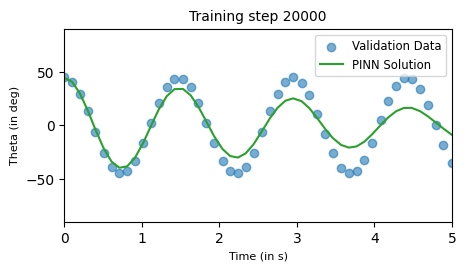

Loss Total     = tensor(0.0055, dtype=torch.float64, grad_fn=<AddBackward0>)
loss_1*coeff_1 = tensor(0.0055, grad_fn=<MulBackward0>)
loss_2*coeff_2 = tensor(3.1468e-05, dtype=torch.float64, grad_fn=<MulBackward0>)
loss_3*coeff_3 = tensor(1.3683e-07, grad_fn=<MulBackward0>)


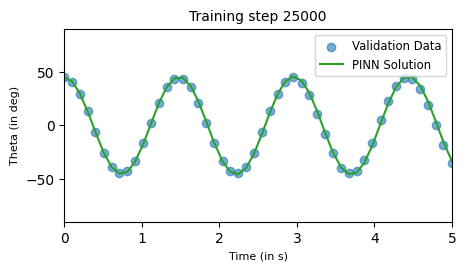

In [12]:
# Assuming FCN is already defined and works correctly
# Ensure all tensors have the correct dtype
t_obs = t_obs.float()
theta_obs = theta_obs.float()

torch.manual_seed(42)

# define a neural network to train
pinn = FCN(1, 1, 32, 3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(t0, t_end, 50).view(-1,1).requires_grad_(True)

# initial condition
t_init = torch.zeros(1, 1).requires_grad_(True)
theta_init = torch.from_numpy( np.radians(45).reshape(1, 1) )
dtheta_dt_init = torch.zeros(1, 1)

# Define the optimizer with separate parameter groups
optimiser = torch.optim.Adam([
    {'params': pinn.parameters(), 'lr': 1e-3},  # Learning rate for the neural network
])

L = 0.5 # length of pendulum
g = 9.8 # acceleration due to gravity
coeff_1 = 1 # weight for "loss_1"
coeff_2 = 100 # weight coeff for "loss_2"
coeff_3 = 1000 # weight coeff for "loss_2"

##############
for i in range(25000):
    
    optimiser.zero_grad()

    # compute physics loss
    theta = pinn(t_physics)
    dtheta_dt = torch.autograd.grad(theta, t_physics, torch.ones_like(theta), create_graph=True)[0]
    d2theta_dt2 = torch.autograd.grad(dtheta_dt, t_physics, torch.ones_like(dtheta_dt), create_graph=True)[0]
    loss_1 = torch.mean( (d2theta_dt2 + g/L*torch.sin(theta))**2 )
    
    # initial cnodition (theta = 45deg)
    theta_init_pred = pinn(t_init)
    loss_2 = torch.mean((theta_init_pred - theta_init)**2)

    # initial cnodition (dtheta_dt = 0)
    dtheta_dt_init_pred = torch.autograd.grad(theta_init_pred, t_init, torch.ones_like(theta_init_pred), create_graph=True)[0]    
    loss_3 = torch.mean((dtheta_dt_init_pred - dtheta_dt_init)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = coeff_1*loss_1 + coeff_2*loss_2 + coeff_3*loss_3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if (i+1) % 5000 == 0 or i == 0:
        print("Loss Total     =", loss)
        print("loss_1*coeff_1 =", coeff_1*loss_1)
        print("loss_2*coeff_2 =", coeff_2*loss_2)
        print("loss_3*coeff_3 =", coeff_3*loss_3)

        # theta prediction for validation dataset
        theta_obs_pred = pinn(t_obs).detach()

        plt.figure(figsize=(5, 2.5))
        plt.scatter(t_obs[:,0], np.degrees(theta_obs[:,0]), label="Validation Data", alpha=0.6)
        plt.plot(t_obs[:,0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="tab:green")

        plt.title(f"Training step {i+1}", fontsize=10)        
        plt.xlabel("Time (in s)", fontsize=8)
        plt.ylabel("Theta (in deg)", fontsize=8)

        plt.axis([0, t_end, -90, 90])
        plt.legend(fontsize="small")
        plt.show()


### Weights

In [10]:
# # Print the weights of each layer
# for name, param in pinn.named_parameters():
#     if param.requires_grad:  # Check if the parameter is trainable
#         print(f"Layer: {name}, Weights: {param.data}")


In [11]:
t_test = torch.ones(1, 1)*4
theta_obs_pred = pinn(t_test).detach()
np.degrees(theta_obs_pred)


C:\Users\E40065690\AppData\Local\Temp\ipykernel_26164\4120111949.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.degrees(theta_obs_pred)


tensor([[-13.7359]])